# Natural Language Processing with Disaster Tweets | Kaggle 

Gunes Evitan의 노트북 NLP with Disaster Tweets - EDA, Cleaning and BERT를 따라하며, 대회 데이터에 대한 데이터 분석, NLP에 대한 특징 엔지니어링 아이디어, 텍스트 정제 및 처리 아이디어, 기준 BERT 모델 또는 라벨이 있는 테스트 묶음에 대한 공부를 하려고 한다. Reference [nlp-with-disaster-tweets-eda-cleaning-and-bert](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

캐글 입문으로 따라했던 노트북 Titanic Data Science Solutions에서 제시한 워크 플로우에 맞춰서 위 노트북을 따라하고자 한다.

## (1) 문제 정의하기

트위터는 긴급 상황에서 중요한 커뮤니케이션 채널이 되었다. 사람들은 실시간으로 관찰중이 긴급 상황을 알릴 수 있기에, 많은 기관이 프로그래밍 방식으로 트위터를 모니터링하는 데 관심을 보이고 있다. 하지만 한 사람의 말이 실제로 재난을 알리는 것인지가 항상 분명하지는 않다. 

이 대회에서는 실제 재해에 대한 트윗과 그렇지 않은 트윗을 예측하는 기계 학습 모델을 구축해야 한다. 사람이 직접 분류한 10,000 개의 트윗 데이터에 액세스할 수 있다.

## (2) 데이터 불러오기

In [4]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [15]:
!pip install tokenization
!pip install tensorflow_hub

In [16]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

In [5]:
df_train = pd.read_csv('input_nlp/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('input_nlp/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


## (3) 데이터 분석

## 1. Keyword and Location
### 1.1 Missing Values

학습 데이터와 테스트 데이터에서 `keyword`와 `location`의 결측값 비율이 동일하다.

- 학습 데이터와 테스트 데이터에서 `keyword`의 0.8%가 누락
- 학습 데이터와 테스트 데이터에서 `location`의 33%가 누락

학습 데이터와 테스트 데이터 간의 결측값 비율이 매우 비슷하기 때문에 대부분 동일한 표본에서 추출된다. 이러한 특징에서 누락된 값은 각각 `no_keyword`와 `no_location`으로 채워진다.

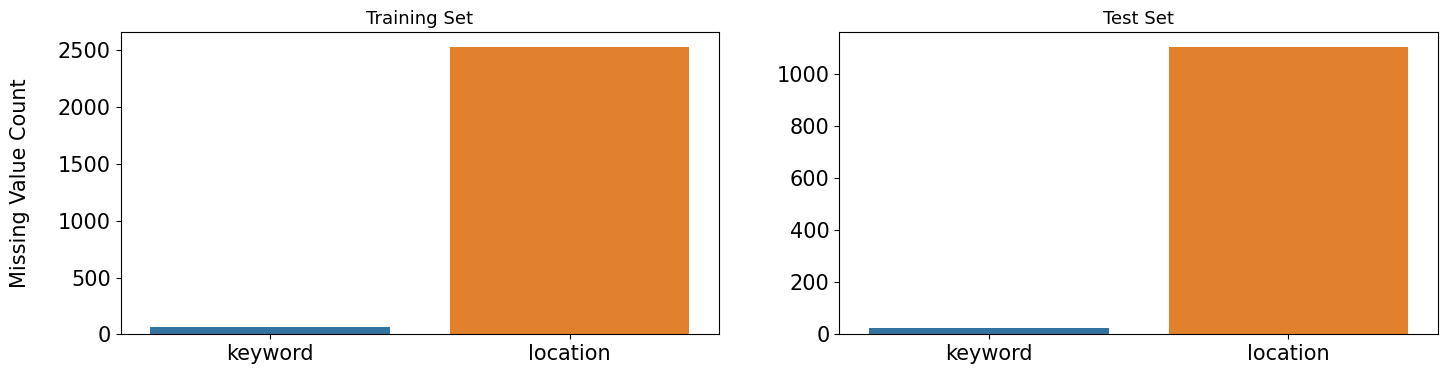

In [7]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

### 1.2 Cardinality and Target Distribution 집합의 크기 및 타켓 분포

위치는 자동으로 생성되지 않고, 사용자에게 입력을 받아야 한다. 그렇기에 `location`은 아주 지저분하고 고유한 값이 너무 많다. 특징(feature)으로 사용해서는 안된다.

다행히도, 일부 단어는 하나의 context에서만 사용할 수 있으므로 `keyword`에 신호가 있다. `keyword`는 트윗 수와 타겟 mean이 매우 다르다. `keyword`는 그 자체로 특징으로 사용하거나 텍스트에 추가하여 사용할 수 있다. 학습 데이터의 모든 단일 `keyword`는 테스트 데이터에도 존재한다. 학습 및 테스트 데이터가 동일한 표본에서 나온 경우, `keyword`에 타겟 인코딩을 사용할 수도 있다.

In [8]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


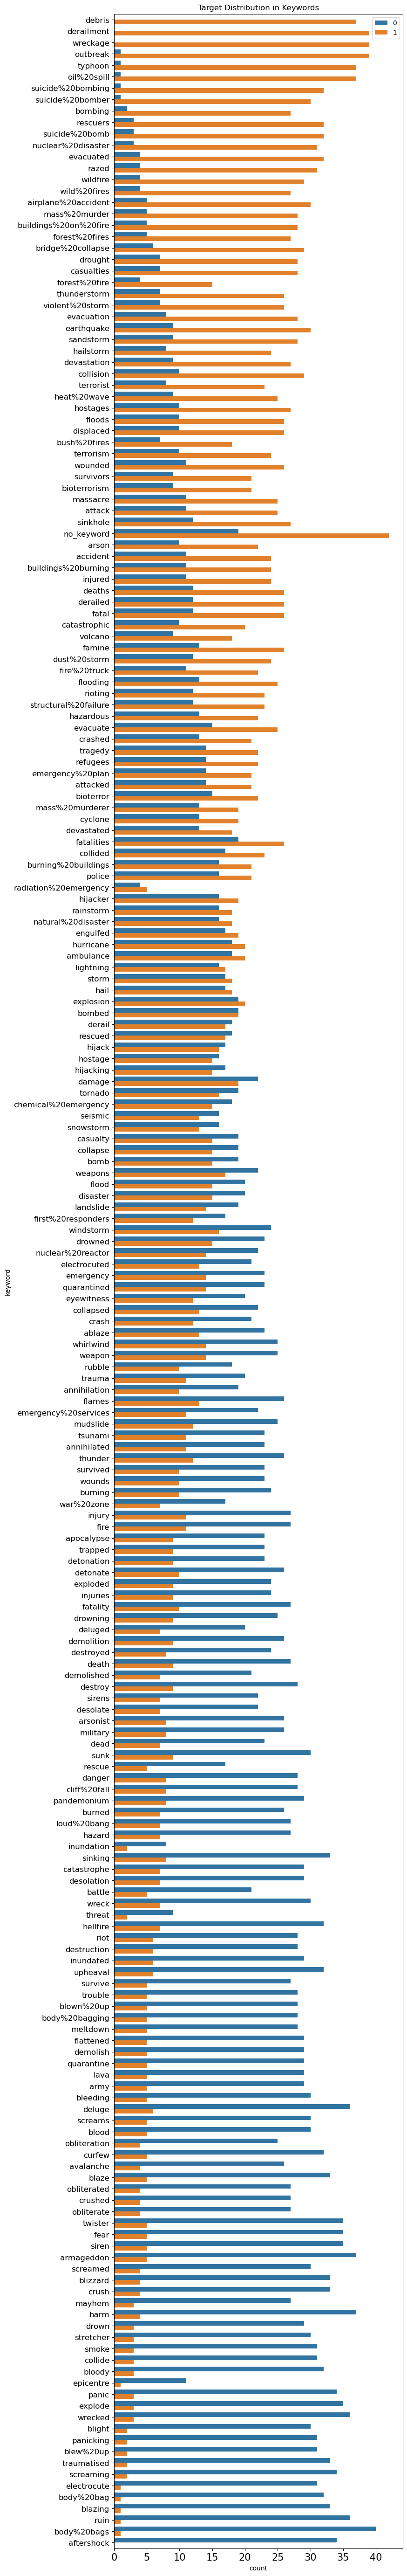

In [9]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

0 (Not disaster) / 1 (Disaster)

## Meta Features

클래스와 데이터 세트의 메타 특징 분포는 재난 트윗을 식별하는 데 도움이 될 수 있다. 재난 트윗은 대부분 뉴스 기관에서 작성되므로 재난 트윗이 비재난 트윗에 비해 더 긴 단어로, 더 형식적으로 작성된 것 같다. 비재난 트윗은 개인 사용자의 트윗이기 때문에 재난 트윗보다 오타가 더 많다. 분석에 사용되는 메타 특징은 다음과 같다.

- `word_count` 텍스트에 있는 단어 수
- `unique_word_count` 텍스트에 있는 고유 단어 수
- `stop_word_count` 텍스트에 있는 불용어 수
- `url_count` 텍스트에 있는 URL 수
- `mean_word_length` 단어의 평균 문자 수
- `char_count` 텍스트에 있는 문자 수
- `punctuation_count` 텍스트에 있는 구두점 수
- `hashtag_count` 텍스트에 있는 해시 테그 수 (#)
- `mention_count` 텍스트에 있는 멘션 수 (@)

In [17]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

학습 및 테스트 데이터에서 모든 메타 특징은 아주 비슷한 분포를 보이므로, 학습 및 테스트 데이터를 동일한 표본에서 추출했다는 것을 또한 증명한다.

모든 메타 특징은 타겟에 대한 정보를 잘 갖고 있지만, `url_count`, `hashtag_count`, `mention_count`와 같은 일부 특징은 충분하게 갖고 있지 않다.

반면에, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` 는 재난과 비재난 트윗에 대한 분포가 아주 다르다. 해당 특징들은 모델에 유용할 것이다.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


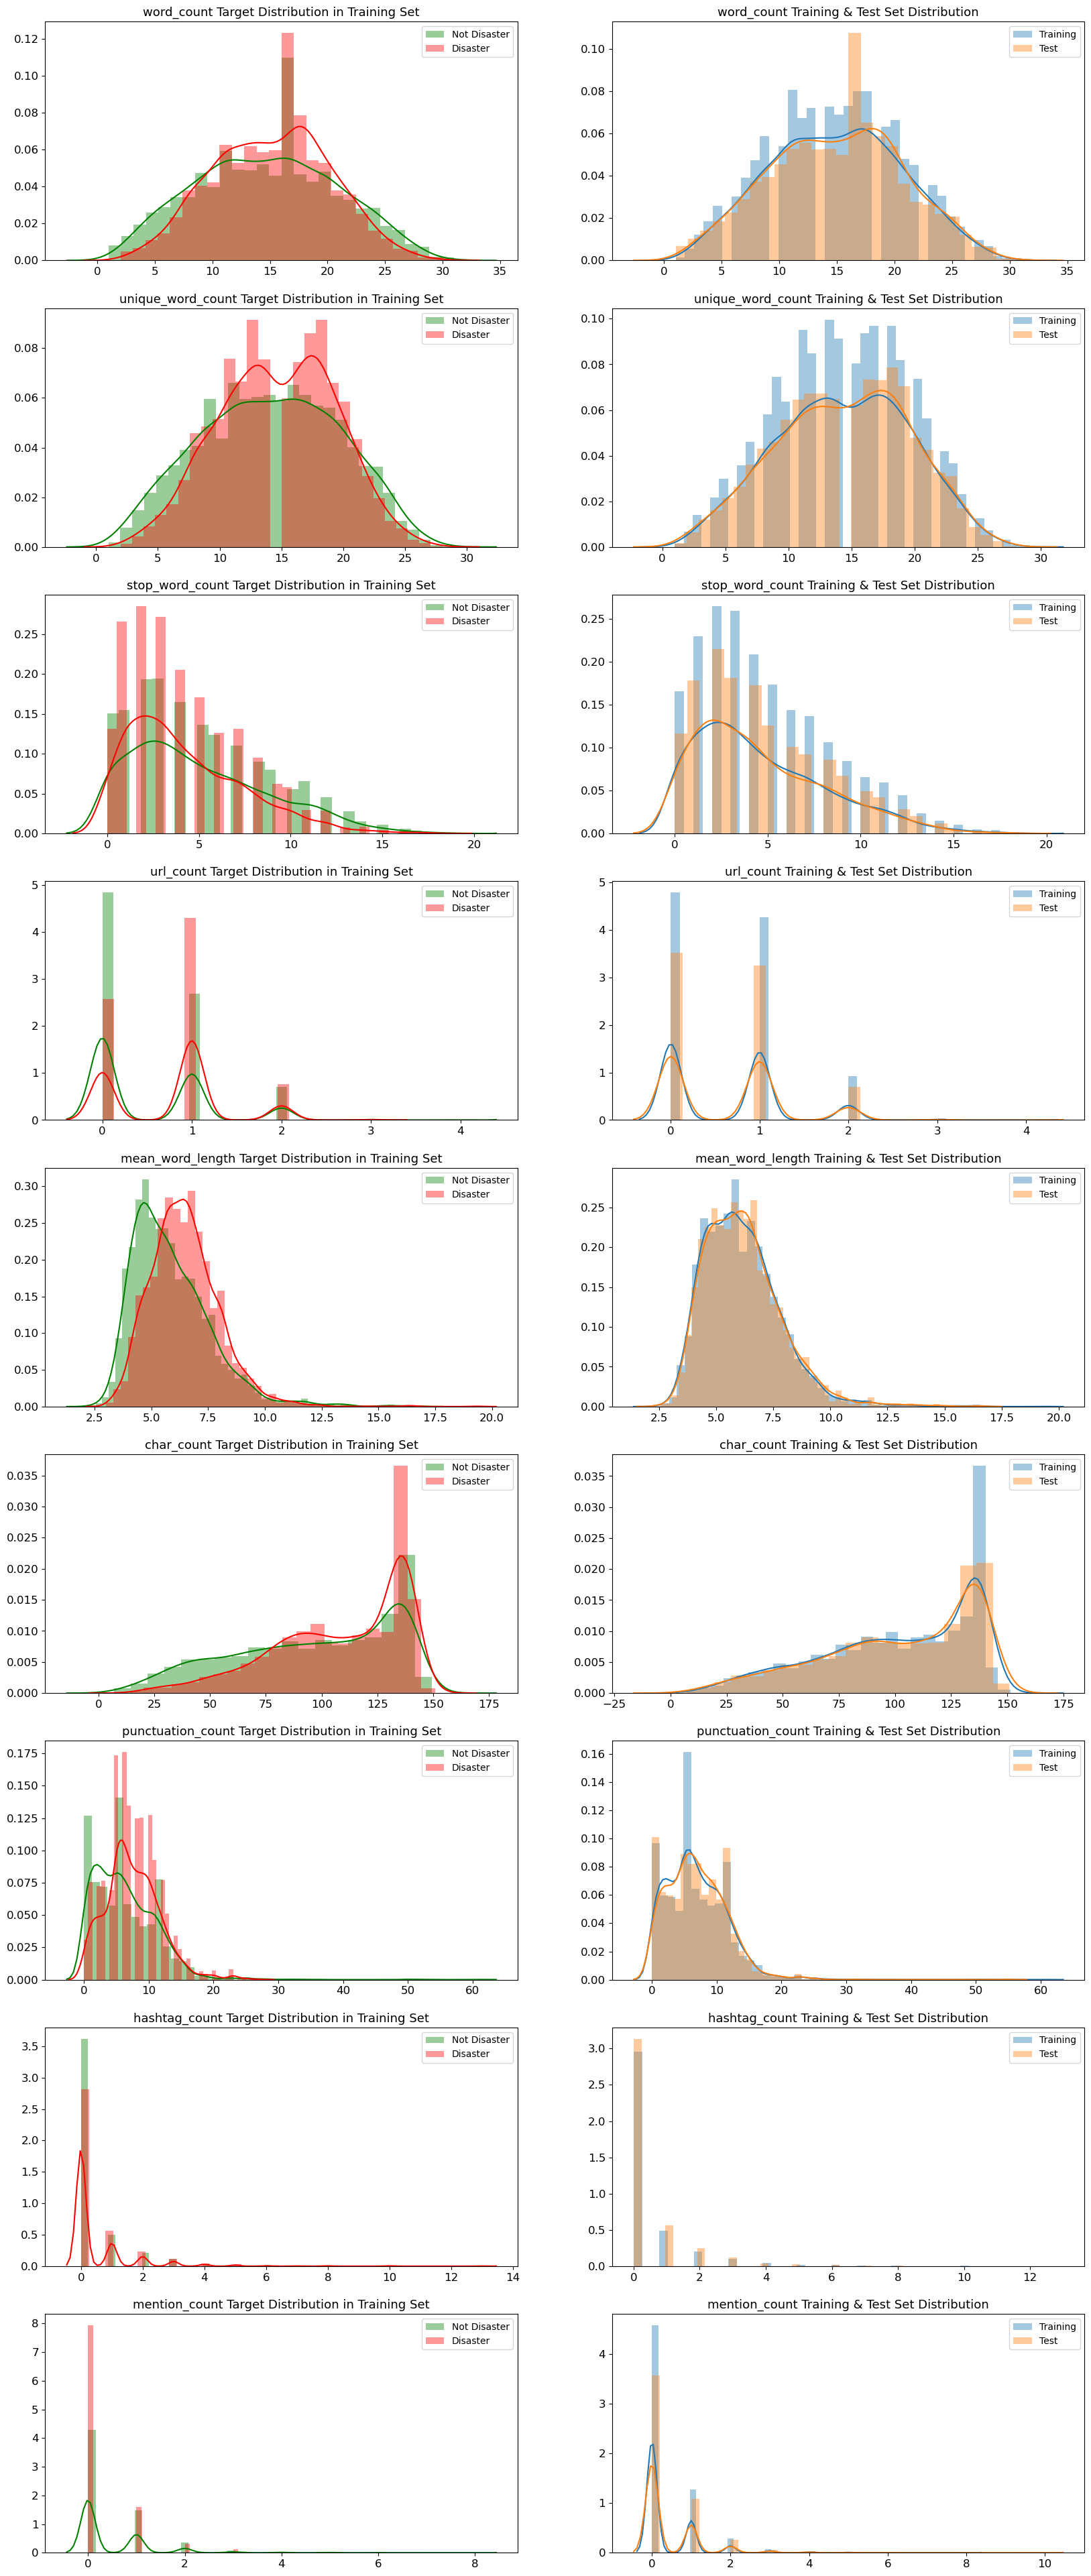

In [18]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

## 3. Target and N-grams
### 3.1 Target

클래스 분포는 0(재해 아님)에 57%, 1(재해)에 43%이다. 클래스는 거의 동등하게 분리되어 있으므로 교차 검증(cross-validation)에서 타겟별로 계층화할 필요가 없다.

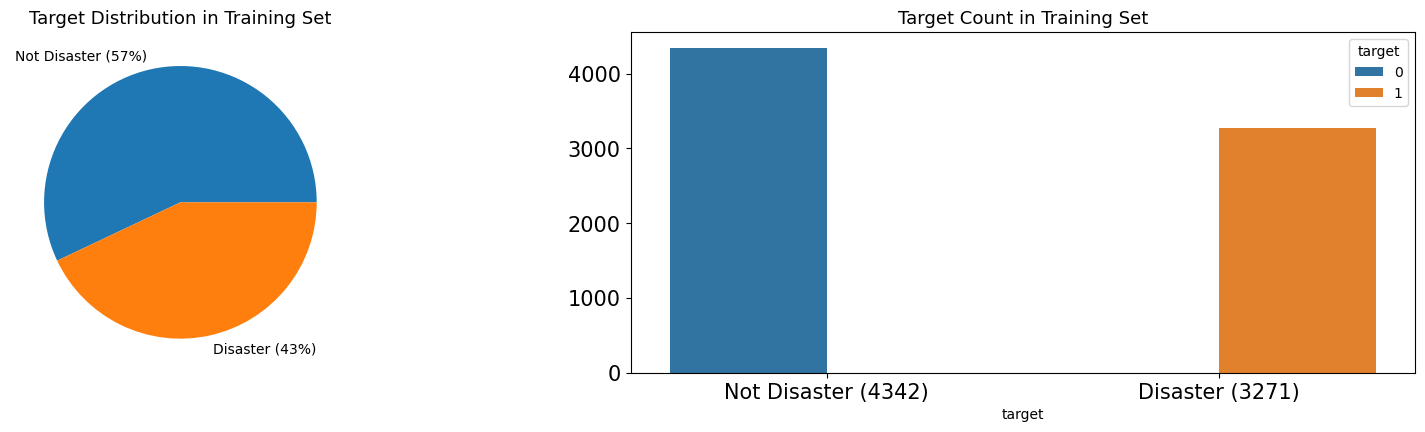

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [20]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

### 3.2 Unigrams



### 3.3 Bigrams


### 3.4 Trigrams


----------------------------------------------------------------------------------

(1) 문제를 정의하고, (2) 데이터를 불러오고, (3) 데이터를 분석했다. 

이제 데이터 전처리와 모델링이 남았다.

## 참고자료

https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert